<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [8]:
# librerias
#
import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem

import pylab as plt

In [4]:
# datos
cc = pd.read_csv('data/cookie_Cats.csv')
cc.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [5]:
# transformacion
cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [11]:
ret_1 = pd.crosstab(cc.retention_1, cc.version)
ret_1

version,gate_30,gate_40
retention_1,,
False,24666,25370
True,20034,20119


In [10]:
ret_7 = pd.crosstab(cc.retention_7, cc.version)
ret_7

version,gate_30,gate_40
retention_7,,
False,36198,37210
True,8502,8279


<AxesSubplot:xlabel='retention_1'>

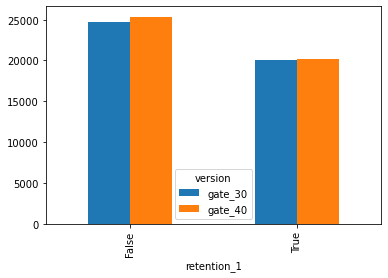

In [12]:
ret_1.plot(kind='bar')

<AxesSubplot:xlabel='retention_7'>

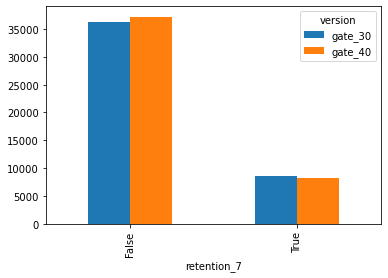

In [13]:
ret_7.plot(kind='bar')

In [3]:
# muestreo


In [14]:
# testeo para retention_1
from scipy.stats import ttest_ind  # testeo con dos muestras independientes

ttest_ind(ret_1.gate_30, ret_1.gate_40)

Ttest_indResult(statistic=-0.11268160703773782, pvalue=0.9205737941653265)

In [15]:
# testeo para retention_7

ttest_ind(ret_7.gate_30, ret_7.gate_40)


Ttest_indResult(statistic=-0.019699952799582008, pvalue=0.9860713811037611)

In [ ]:
# conclusiones
# Explica detalladamente las conclusiones obtenidas de. tu testeo.
# El valor de pvalue es superior en ambos casos, por lo que no rechazamos H0, es decir, no existe una diferencia significativa para 1 y 7 días de retención entre gate_30 y gate_40.

## AB Testing with Bayes

In [16]:
def bayes(priori, verosimilitud):  
    
    marginal=sum(np.multiply(priori, verosimilitud))
    
    posteriori=np.divide(np.multiply(priori, verosimilitud), marginal)
    
    return posteriori

In [3]:
from scipy.stats import bernoulli, beta

In [17]:
ret_1.gate_30

retention_1
False    24666
True     20034
Name: gate_30, dtype: int64

In [29]:
#priori y verosimilitud de retention_1
priori1 = [1/2, 1/2]

v_1 = ((ret_1.gate_30[1] / (ret_1.gate_30[0] + ret_1.gate_30[1])), (ret_1.gate_40[1] / (ret_1.gate_40[0] + ret_1.gate_40[1])))

In [30]:
# 
bayes(priori1, v_1)

array([0.50331576, 0.49668424])

In [32]:
#priori y verosimilitud de retention_7
priori7 = [1/2, 1/2]

v_7 = ((ret_7.gate_30[1] / (ret_7.gate_30[0] + ret_7.gate_30[1])), (ret_7.gate_40[1] / (ret_7.gate_40[0] + ret_7.gate_40[1])))

In [33]:
bayes(priori7, v_7)

array([0.51101729, 0.48898271])

#### Forma + correcta

In [39]:
# para retention_1
# los datos son conocidos : impresiones y conversiones para test y control

imps_ctrl, convs_ctrl = 44700, 20034   # entrar, comprar
imps_test, convs_test= 45489, 20119


CR_ctrl = convs_ctrl/imps_ctrl
CR_test = convs_test/imps_test

f'TASAS: Control={CR_ctrl}, Test={CR_test}'

'TASAS: Control=0.4481879194630872, Test=0.44228274967574577'

In [40]:
# aprioris

a_C, b_C = convs_ctrl+1, imps_ctrl-convs_ctrl+1
a_T, b_T = convs_test+1, imps_test-convs_test+1

beta_control=beta(a_C, b_C)
beta_test=beta(a_T, b_T)

In [41]:
beta_control.mean(), beta_test.mean()

(0.44819023757326293, 0.44228528719966587)

In [42]:
x=np.linspace(0.42, 0.47, 1000)

def plot(betas, nombres):
    
    for bet, nom in zip(betas, nombres):
        
        y=bet.pdf(x)
        y_media=bet.mean()
        y_std=bet.std()
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
    plt.legend()
    plt.show();

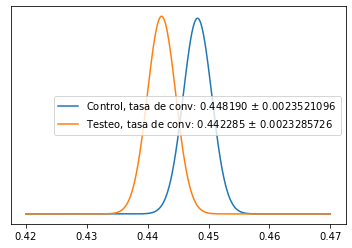

In [43]:
plot([beta_control, beta_test], ['Control', 'Testeo'])

In [44]:
salto=(beta_test.mean() - beta_control.mean())/beta_control.mean()

salto

-0.013175098158249857

In [45]:
from bayes import *
prob=calc_prob(beta_test, beta_control)

In [46]:
%pip install mpmath

from mpmath import betainc   # integral de beta

Note: you may need to restart the kernel to use updated packages.


In [48]:
'''El test aumenta la tasa de conversion en un {:2.2f}%, con una probabilidad del {:2.2f}%'''.format(salto*100,(1-prob)*100)

'El test aumenta la tasa de conversion en un -1.32%, con una probabilidad del 96.28%'

In [49]:
# para retention_7
# los datos son conocidos : impresiones y conversiones para test y control

imps_ctrl, convs_ctrl = 44700, 8502   # entrar, comprar
imps_test, convs_test= 45489, 8279


CR_ctrl = convs_ctrl/imps_ctrl
CR_test = convs_test/imps_test

f'TASAS: Control={CR_ctrl}, Test={CR_test}'



'TASAS: Control=0.19020134228187918, Test=0.18200004396667327'

In [50]:
# aprioris

a_C, b_C = convs_ctrl+1, imps_ctrl-convs_ctrl+1
a_T, b_T = convs_test+1, imps_test-convs_test+1

beta_control=beta(a_C, b_C)
beta_test=beta(a_T, b_T)

In [51]:
beta_control.mean(), beta_test.mean()

(0.19021520289919913, 0.18201402475214878)

In [52]:
x=np.linspace(0.16, 0.21, 1000)

def plot(betas, nombres):
    
    for bet, nom in zip(betas, nombres):
        
        y=bet.pdf(x)
        y_media=bet.mean()
        y_std=bet.std()
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
    plt.legend()
    plt.show();

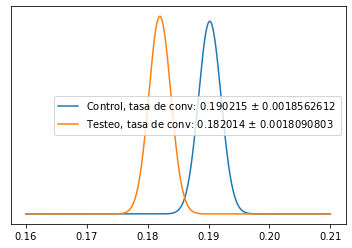

In [53]:
plot([beta_control, beta_test], ['Control', 'Testeo'])

In [54]:
from bayes import *
prob=calc_prob(beta_test, beta_control)

In [55]:
salto=(beta_test.mean() - beta_control.mean())/beta_control.mean()

salto

-0.04311526114658881

In [57]:
'''El test aumenta la tasa de conversion en un {:2.2f}%, con una probabilidad del {:2.2f}%'''.format(salto*100, (1-prob)*100)

'El test aumenta la tasa de conversion en un -4.31%, con una probabilidad del 99.92%'